In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from sklearn.datasets import fetch_california_housing
from sklearn.preprocessing import StandardScaler

In [3]:
cali = fetch_california_housing()
cali_df = pd.DataFrame(cali['data'], columns=cali['feature_names'])
cali_df['Target'] = cali['target']
cali_df

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,Target
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422
...,...,...,...,...,...,...,...,...,...
20635,1.5603,25.0,5.045455,1.133333,845.0,2.560606,39.48,-121.09,0.781
20636,2.5568,18.0,6.114035,1.315789,356.0,3.122807,39.49,-121.21,0.771
20637,1.7000,17.0,5.205543,1.120092,1007.0,2.325635,39.43,-121.22,0.923
20638,1.8672,18.0,5.329513,1.171920,741.0,2.123209,39.43,-121.32,0.847


In [4]:
data = torch.from_numpy(cali_df.values).float()
data.shape

torch.Size([20640, 9])

In [5]:
X = data[:, :-1]
y = data[:, -1:]
scaler = StandardScaler().fit(X)
X_sc = torch.from_numpy(scaler.transform(X).round(4)).float()
X_sc.shape[-1], y.shape[-1]

(8, 1)

In [6]:
n_epochs = 1000
batch_size = 256
print_interval = 100

In [7]:
model = nn.Sequential(
    nn.Linear(X_sc.shape[-1], 7),
    nn.LeakyReLU(),
    nn.Linear(7, 5),
    nn.LeakyReLU(),
    nn.Linear(5, 3),
    nn.LeakyReLU(),
    nn.Linear(3, y.shape[-1])
)
optimizer = optim.Adam(model.parameters())

In [8]:
for epoch in range(n_epochs):
    indices = torch.randperm(X_sc.shape[0])
    X_ = torch.index_select(X_sc, dim=0, index=indices)
    y_ = torch.index_select(y, dim=0, index=indices)
    X_ = X_.split(batch_size, dim=0)
    y_ = y_.split(batch_size, dim=0)

    y_hat = []
    total_loss = 0

    for X_i, y_i in zip(X_, y_):
        y_hat_i = model(X_i)
        loss = F.mse_loss(y_hat_i, y_i)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += float(loss)
        y_hat += [y_hat_i]
    
    total_loss = total_loss / len(X_)

    if (epoch + 1) % print_interval == 0:
        print(f'Epoch {epoch + 1}: loss {total_loss:.4f}')

y_hat = torch.concat(y_hat, dim=0)
y = torch.concat(y_, dim=0)

Epoch 100: loss 0.3356
Epoch 200: loss 0.3179
Epoch 300: loss 0.3111
Epoch 400: loss 0.3077
Epoch 500: loss 0.3040
Epoch 600: loss 0.3036
Epoch 700: loss 0.3028
Epoch 800: loss 0.3029
Epoch 900: loss 0.3021
Epoch 1000: loss 0.3018


In [9]:
result_df = pd.DataFrame(torch.concat([y, y_hat], dim=1).detach_().numpy(), columns=['y', 'y_hat']).clip(lower=0, upper=5)
result_df

,y,y_hat
0,1.482,1.689405
1,2.025,1.601727
2,3.000,3.386759
3,5.000,3.162524
4,1.385,1.468861
...,...,...
20635,1.385,0.891344
20636,1.656,1.988346
20637,1.848,1.657619
20638,2.841,3.475185


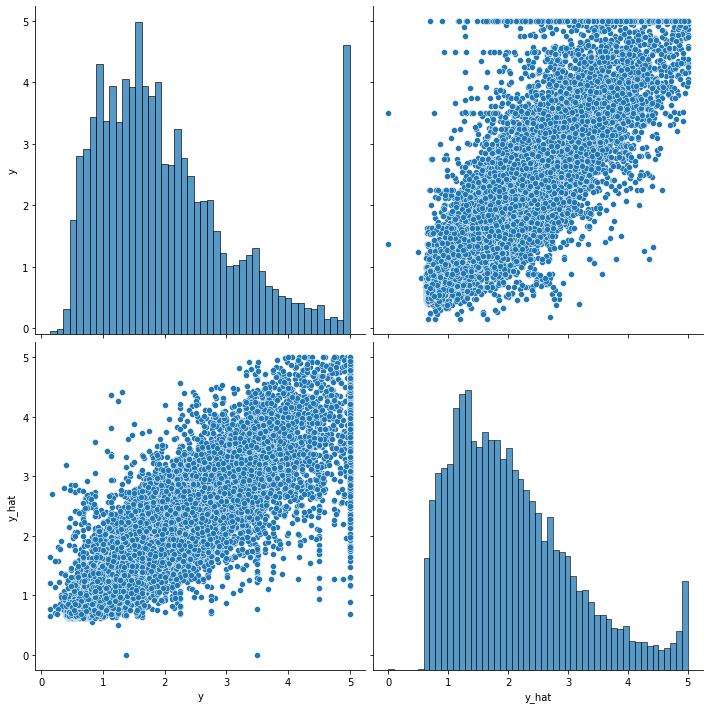

In [10]:
sns.pairplot(result_df, height=5)
plt.show()